# Introduction

### To build sentiment analysis based on dataset from: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

## Importing Python Libraries

In [ ]:
import pandas as pd
import re
import spacy
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [2]:
# To download spacy corpus. Please enable one of the required.
# For bash shell
! python -m spacy download en_core_web_sm

#  For windows
# %% python -m spacy download en

/Users/everhett/Projects/python-ws/imdb-sentiment-analysis/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 22.0 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


# Exploratory data analysis 

### Let's explore the dataset to understand the features before preparing for building the sentiment prediction models.

In [3]:
# Define the datasets used in stages for building the models.
raw_dataset_path = 'data/imdb-movie-review-kaggle-laskhmipathi.csv'

# After encoding the classes to binary values (1: positive and 0: negative).
encoded_dataset_path = 'data/1-imdb-movie-review-encoded.csv'

# The final preprocessed files for building the models.
processed_dataset_path = 'data/2-imdb-movie-review-processed.csv'

In [4]:
# Let's glance at the dataset.
data = pd.read_csv(raw_dataset_path, encoding="ISO-8859-1")
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [5]:
# The dataset has the following data types.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [6]:
# Let's investigate if the dataset has missing values.
data.isnull().sum()

review       0
sentiment    0
dtype: int64

In [7]:
# Let's investigate the distribution sentiment class distribution.
data['sentiment'].value_counts()

sentiment
positive    25000
negative    25000
Name: count, dtype: int64

<Axes: xlabel='sentiment'>

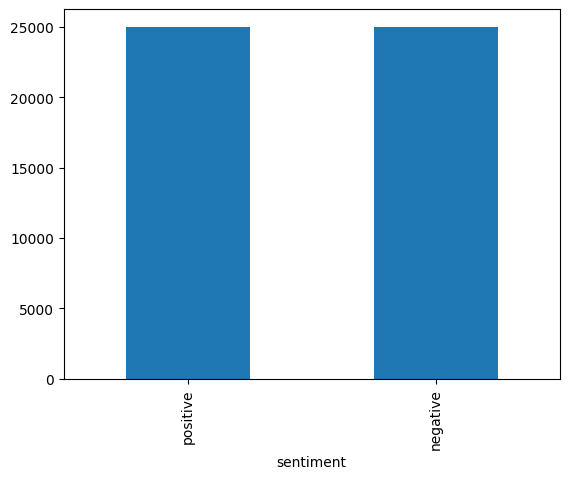

In [8]:
# The dataset has well-balanced classes for positive and negative sentiment (1:1).
# Let's visualize it in a bar chart.
data['sentiment'].value_counts().plot.bar()

# Identifying special character in the dataset
We will explore the noise in the data before building the model in this section. \
We will remove the noise during the preprocessing later.

## Hyperlink

In [9]:
import re
import pandas as pd

# Define a regex pattern for URLs
url_pattern = r'https?://(?:www\.)?\S+'

# Let's explore whether the dataset contains hyperlinks.
temp = []
for index, row in data.iterrows():
    review_text = row['review']
    text_list = re.findall(url_pattern, review_text)
    if len(text_list) > 0:
        temp.append(text_list)

print(f'Dataset contains {len(temp)} number of hyperlinks.')
tmp = pd.Series(temp)
tmp.head()

Dataset contains 119 number of hyperlinks.


0                         [http://www.invocus.net)]
1           [http://blog.myspace.com/locoformovies]
2    [http://www.comingsoon.net/films.php?id=36310]
3                     [http://tinyurl.com/znyyq<br]
4              [http://imdb.com/name/nm0834754/bio]
dtype: object

## Special Character

In [10]:
# Define a regex pattern for special character
special_character = r'[#,.\-$!/()?%_√Ø¬ø¬Ω:&|;]'

# Let's explore whether the dataset contains special character.
temp = []
for index, row in data.iterrows():
    review_text = row['review']
    text_list = re.findall(special_character, review_text)
    if len(text_list) > 0:
        temp.append(text_list)

print(f'Dataset contains {len(temp)} number of special characters.')
tmp = pd.Series(temp)
tmp.head()

Dataset contains 49992 number of special characters.


0    [., ,, ., /, /, ,, ., ,, ., ,, ., ,, ., /, /, ...
1    [., /, /, -, -, -, ,, ,, ., /, /, -, !, ,, ., ...
2    [,, -, ., ,, (, ), ., :, ,, ., /, /, (, ?, ), ...
3    [(, ), &, ., /, /, ., ., ., ,, ., /, /, ,, !, ...
4    [., ., ., ,, ., /, /, ,, ., ,, ,, ., ,, ., ., ...
dtype: object

## Date

In [11]:
# Define a regex pattern for date
date_pattern = r'\d{1,4}[\/\-]\d{1,2}[\/\-]\d{1,4}'

# Let's explore whether the dataset contains date.
temp = []
for index, row in data.iterrows():
    review_text = row['review']
    text_list = re.findall(date_pattern, review_text)
    if len(text_list) > 0:
        temp.append(text_list)

print(f'Dataset contains {len(temp)} number of date.')
tmp = pd.Series(temp)
tmp.head()

Dataset contains 209 number of date.


0      [4/25/08]
1        [7-1/2]
2    [5/28/2000]
3       [7/3/40]
4    [6/20/2009]
dtype: object

## Stand Alone Number

In [12]:
# Define a regex pattern for stand-alone number
number= r'\d+'

# Let's explore whether the dataset stand-alone number.
temp = []
for index, row in data.iterrows():
    review_text = row['review']
    text_list = re.findall(number, review_text)
    if len(text_list) > 0:
        temp.append(text_list)

print(f'Dataset contains {len(temp)} stand alone number.')
tmp = pd.Series(temp)
tmp.head()

Dataset contains 28005 stand alone number.


0         [1]
1         [2]
2     [3, 10]
3    [15, 25]
4        [10]
dtype: object

## br, @

In [13]:
# Define a regex pattern for br (HTML break line) and @ (mention) tags
number= r'\bRT\b|@[A-Za-z0-9_]+|\bbr\b'

# Let's explore whether the dataset br mentions @.
temp = []
for index, row in data.iterrows():
    review_text = row['review']
    text_list = re.findall(number, review_text)
    if len(text_list) > 0:
        temp.append(text_list)

print(f'Dataset contains {len(temp)} br, mentions @.')
tmp = pd.Series(temp)
tmp.head()

Dataset contains 29232 br, mentions @.


0            [br, br, br, br, br, br]
1            [br, br, br, br, br, br]
2                    [br, br, br, br]
3            [br, br, br, br, br, br]
4    [br, br, br, br, br, br, br, br]
dtype: object

## Smiley

In [14]:
# Define a regex pattern for smileys
smiley_pattern = r"(:\)|:-\)|;d|:-E|:\(|:-\(|:-<|:-P|:O|:-@|:@|:-\$|:\\|:#|:X|:\^\)|:-&|\$_\$|@@|:-!|:-D|:-0|O\.O|<\(-_-\)>|d\[-_-\]b|;\)|O:-\)|O\*\)|\(:-D\)|=\^.\^=|\^_\^|:-?P|:-?O|:-?3|:-?\])"

# Check for smileys in the dataset
temp = []
for index, row in data.iterrows():
    review_text = row['review']
    smiley_list = re.findall(smiley_pattern, review_text)
    if smiley_list:
        temp.append(smiley_list)

print(f'Dataset contains {len(temp)} number of reviews with smileys.')
tmp = pd.Series(temp)
tmp.head()

Dataset contains 684 number of reviews with smileys.


0    [:)]
1    [;)]
2    [;)]
3    [:3]
4    [:3]
dtype: object

## Contraction

In [15]:
# Define a regex pattern for contractions
contraction_pattern = r"\b\w+'\w+\b"

# Check for contractions in the dataset
temp = []
for index, row in data.iterrows():
    review_text = row['review']
    contractions_found = re.findall(contraction_pattern, review_text)
    if contractions_found:
        temp.append(contractions_found)

print(f"Dataset contains {len(temp)} reviews with contractions.")
tmp = pd.Series(temp)
tmp.head()

Dataset contains 43839 reviews with contractions.


0    [you'll, wouldn't, doesn't, couldn't, who'll, ...
1                              [master's, Halliwell's]
2                                 [I'd, Woody's, I've]
3                           [there's, there's, you're]
4                   [Mattei's, Schnitzler's, Mattei's]
dtype: object

# Data Preprocessing

Looks, like the dataset has well-balanced classes for building the sentiment analysis. \
In this section, we will prepare the dataset for building the ML models by removing the noise in the data.

In [16]:
# Convert the sentiment classes from categorical to numeric representation.
data["sentiment"] = data["sentiment"].map({"positive": 1, "negative": 0})

In [17]:
# Let's verify the data after conversion.
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [18]:
# Save to new CSV with classes encoded
data.to_csv(encoded_dataset_path, index=False)

## Remove the identified noise in the dataset.
#### NOTE: Takes around 15 to 30 minutes.

In [ ]:
# Load spaCy English model
nlp = spacy.load("en_core_web_sm")

# Define spaCy's stop words
stop_words = nlp.Defaults.stop_words

# Contractions dictionary
contractions = {
    "can't": "cannot", "won't": "will not", "i'm": "i am", "she's": "she is",
    "he's": "he is", "they're": "they are", "we're": "we are", "i've": "i have",
    "you're": "you are", "they've": "they have", "i'd": "i would", "we'd": "we would",
    "couldn't": "could not", "wouldn't": "would not", "shouldn't": "should not",
    "don't": "do not", "haven't": "have not", "omg": "oh my god",
    "aren't": "are not", "didn't": "did not", "doesn't": "does not", "hadn't": "had not",
    "hasn't": "has not", "isn't": "is not", "it's": "it is", "let's": "let us",
    "ma'am": "madam", "mightn't": "might not", "might've": "might have",
    "mustn't": "must not", "must've": "must have", "needn't": "need not",
    "o'clock": "of the clock", "shan't": "shall not", "she'd": "she would",
    "she'll": "she will", "that's": "that is", "there's": "there is",
    "there'd": "there would", "they'd": "they would", "they'll": "they will",
    "wasn't": "was not", "weren't": "were not", "what'll": "what will",
    "what're": "what are", "what's": "what is", "what've": "what have",
    "where's": "where is", "who'd": "who would", "who'll": "who will",
    "who're": "who are", "who's": "who is", "who've": "who have",
    "why's": "why is", "would've": "would have", "you'd": "you would",
    "you'll": "you will", "you've": "you have", "y'all": "you all"
}

# Emojis dictionary
emojis_dict = {
    ':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad',
    ':-(': 'sad', ':-<': 'sad', ':-P': 'raspberry', ':O': 'surprised',
    ':-@': 'shocked', ':@': 'shocked', ':-$': 'confused', r':\\': 'annoyed',
    ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
    '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.O': 'confused',
    '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ':-)': 'sadsmile', ';)': 'wink',
    'O:-)': 'angel', 'O*)': 'angel', '(:-D': 'gossip', '=^.^=': 'cat'
}

def preprocess_text(text):
    # 1️⃣ Text Cleaning
    text = re.sub(r'https?:\/\/[\S]+', '', text)                # Remove hyperlinks
    text = re.sub(r'[#,.\-$!/()?%_√Ø¬ø¬Ω:&|;]', ' ', text)      # Replace special characters with a space
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)                  # Remove mentions
    text = re.sub(r'\d{1,4}[\/\-]\d{1,2}[\/\-]\d{1,4}', '', text) # Remove dates (e.g. 12/24/03)
    text = re.sub(r'\d+', '', text)                             # Remove standalone numbers
    text = re.sub(r'\bbr\b', '', text)                          # Remove noise "br"


    # 2️⃣ Contraction Expansion
    for contraction, full_form in contractions.items():
        text = re.sub(r'\b' + re.escape(contraction) + r'\b', full_form, text, flags=re.IGNORECASE)
    
    # 3️⃣ Emoji Replacement
    for emoji, meaning in emojis_dict.items():
        text = text.replace(emoji, f' {meaning} ')
    
    # 4️⃣ Normalisation: convert to lowercase and remove extra spaces
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip()
    
    # 5️⃣ Tokenization, Lemmatisation, and Stopword Removal using spaCy
    doc = nlp(text)
    lemmatized_words = [token.lemma_ for token in doc]
    filtered_words = [word for word in lemmatized_words if word not in stop_words and word.isalpha()]
    
    return " ".join(filtered_words)

# Read the CSV with encoding specified
data = pd.read_csv(encoded_dataset_path, encoding='ISO-8859-1')

# Apply preprocessing to the "review" column
data["review"] = data["review"].astype(str).apply(preprocess_text)

# Display the processed dataset
print("\nProcessed Dataset:")
print(data.head().to_string())

# Save the processed dataset into CSV
data.to_csv(processed_dataset_path, index=False)

# Exploratory data analysis after pre-processing

In [19]:
# Let's glance at the dataset.
data = pd.read_csv(processed_dataset_path, encoding="ISO-8859-1")
data.head()

,review,sentiment
0,reviewer mention watch oz episode hook right e...,1
1,wonderful little production filming technique ...,1
2,I think wonderful way spend time hot summer we...,1
3,basically family little boy jake think zombie ...,0
4,petter mattei love time money visually stunnin...,1


In [20]:
# The dataset has the following rows and columns.
data.shape

(50000, 2)

## Word Cloud - Positive Sentiment

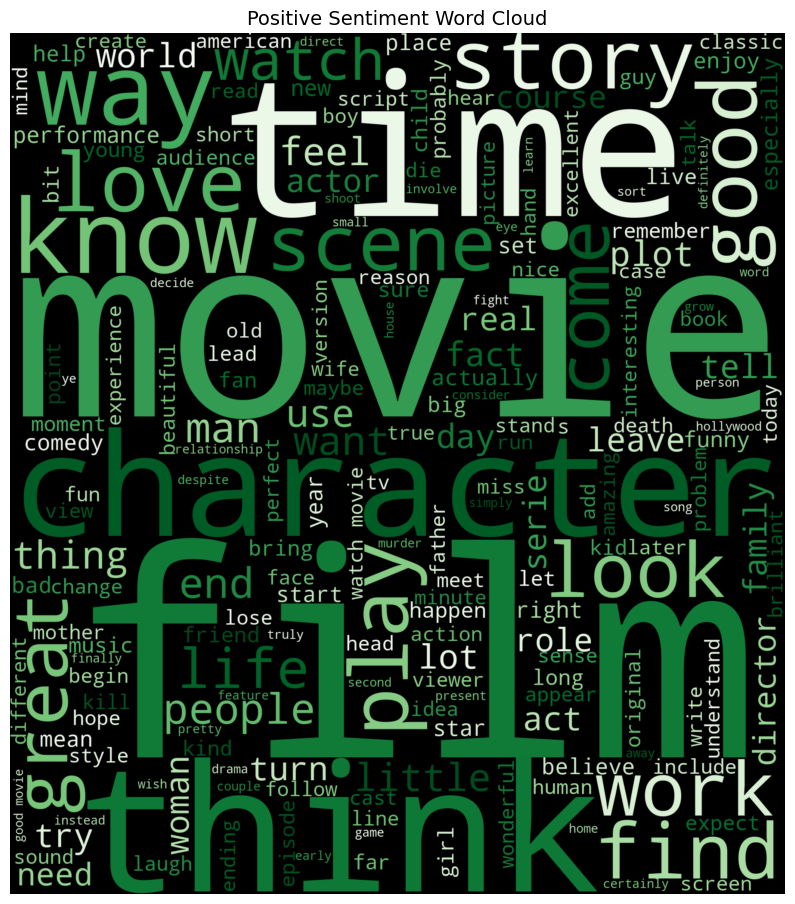

In [21]:
# Filter positive and negative sentiment reviews
positive_text = " ".join(data[data["sentiment"] == 1]["review"])  # Positive sentiment

# Create Word Clouds
wordcloud_positive = WordCloud(width=1800, height=2000, background_color='black', colormap='Greens').generate(positive_text)

# Plot Word Clouds
plt.figure(figsize=(22, 18))

# Positive Sentiment Word Cloud
plt.subplot(1, 2, 2)
plt.imshow(wordcloud_positive, interpolation="bilinear")
plt.axis("off")
plt.title("Positive Sentiment Word Cloud", fontsize=14)

# Show the plots
plt.show()

## Word Cloud Negative Sentiment

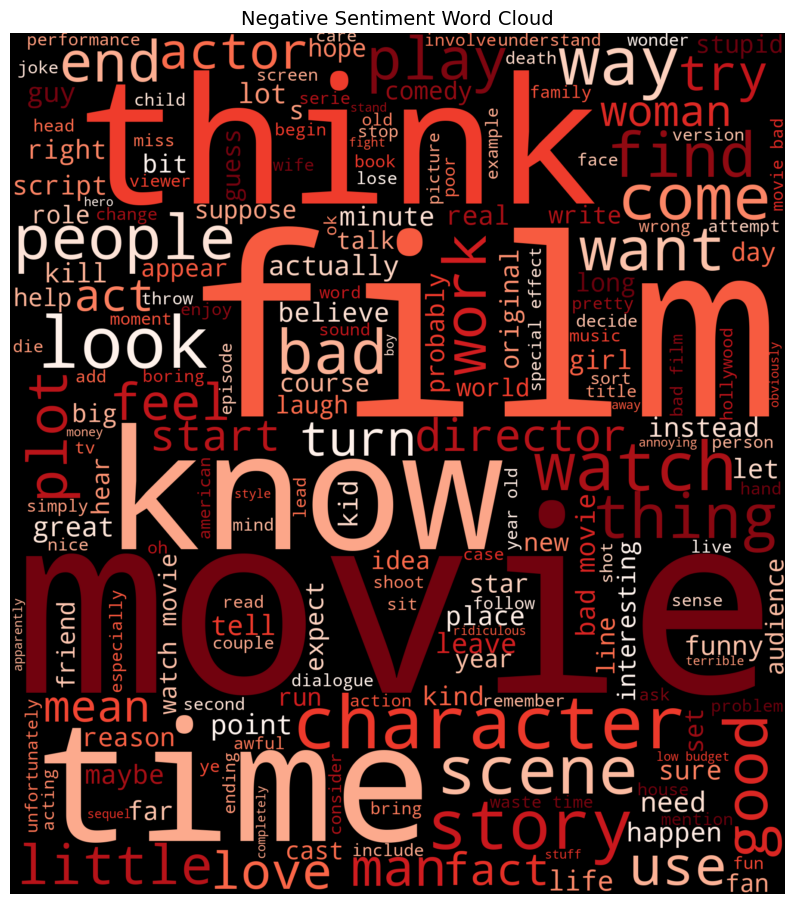

In [22]:
# Filter positive and negative sentiment reviews
negative_text = " ".join(data[data["sentiment"] == 0]["review"])  # Negative sentiment

# Create Word Clouds
wordcloud_negative = WordCloud(width=1800, height=2000, background_color='black', colormap='Reds').generate(negative_text)

# Plot Word Clouds
plt.figure(figsize=(22, 18))

# Negative Sentiment Word Cloud
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_negative, interpolation="bilinear")
plt.axis("off")
plt.title("Negative Sentiment Word Cloud", fontsize=14)

# Show the plots
plt.show()

# Conclusion
The dataset had few noise, we have explored them in the EDA and preprocessing sections. \
Next, we will use the preprocessed `data/2-imdb-movie-review-processed.csv` dataset for building the model.